In [446]:
import datetime

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt

In [447]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [448]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

def entrenar_modelo(df):
    y = df.Price.values.reshape(-1, 1)
    x = df.drop(columns=['Price'])
    name_columns = x.columns
    y = standar_scaler.fit_transform(y)
    x = standar_scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=name_columns)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    ml = sm.OLS(y_train, sm.add_constant(x_train))
    ml_results = ml.fit()
    y_pred = ml_results.predict(sm.add_constant(x_test))
    print("Mean squared error: %.4f" % mean_squared_error(y_test,y_pred))
    return ml_results



#### Leer Dataset

In [449]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


#### Análisis Variables

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [451]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### ID, Model, Cylinders (no tener en cuenta)

In [452]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [453]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [454]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [455]:
df = df.drop(columns=drop_columns)

In [456]:
correlations = df.corr()
correlations.style.background_gradient(cmap='Greens')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
Price,1.000000,-0.876590,-0.018138,0.885159,-0.569960,0.314990,0.108905,0.033081,0.126389,0.185326,0.063104,0.219197,0.581198,0.197802,0.028133,0.146627,0.306138,0.093588,0.248974,0.429259,0.588262,0.601292,0.481374,0.343458,0.356518,0.064275,-0.041887,0.222083,0.164121,0.102569,0.108564,-0.043179,-0.172369,-0.039536,0.054084,-0.038516
Age_08_04,-0.876590,1.000000,-0.123255,-0.983661,0.505672,-0.156622,-0.108150,0.031717,-0.098084,-0.148359,-0.005364,-0.198431,-0.470253,-0.164658,0.006865,-0.152563,-0.412887,-0.105406,-0.329017,-0.403600,-0.426259,-0.719449,-0.510895,-0.279631,-0.283856,-0.069192,0.013791,-0.126895,-0.110988,-0.116751,-0.040045,0.012857,0.188720,0.002389,-0.097740,0.092611
Mfg_Month,-0.018138,-0.123255,1.000000,-0.057416,-0.020630,-0.039312,0.030266,0.009146,0.037387,-0.012069,-0.013063,0.031373,-0.002167,-0.005771,-0.003863,0.029010,0.072532,0.003756,0.076749,0.057088,-0.049017,0.017715,-0.016736,0.010055,0.025185,-0.055495,0.031601,-0.033504,0.052789,0.023245,0.023506,0.032576,-0.042170,0.001289,0.051501,-0.049646
Mfg_Year,0.885159,-0.983661,-0.057416,1.000000,-0.504974,0.164697,0.103310,-0.033567,0.091892,0.151442,0.007766,0.193934,0.473478,0.166697,-0.006206,0.148218,0.402215,0.105359,0.317075,0.395674,0.437718,0.720567,0.517008,0.279490,0.280996,0.079676,-0.019607,0.133737,0.102080,0.113237,0.036022,-0.018844,-0.182206,-0.002637,0.088986,-0.084162
KM,-0.569960,0.505672,-0.020630,-0.504974,1.000000,-0.333538,-0.080503,-0.081854,0.102683,-0.036197,0.015023,0.278165,-0.028598,-0.212851,0.001438,-0.138942,-0.177203,-0.018012,-0.139275,-0.133057,-0.258221,-0.353862,-0.266826,-0.125177,-0.156242,0.007397,0.013661,-0.074327,-0.044784,-0.045658,-0.013599,0.015770,0.084153,0.144016,0.403060,-0.433160
HP,0.314990,-0.156622,-0.039312,0.164697,-0.333538,1.000000,0.058712,0.013144,0.035856,0.092424,0.209477,-0.298432,0.089614,0.140026,0.022701,0.076163,0.057832,0.025137,0.017644,0.241134,0.244957,0.129715,0.102300,0.250122,0.265593,0.048850,0.020998,0.210571,-0.006027,0.010908,0.206784,0.019919,0.068271,0.062109,-0.533453,0.489110
Met_Color,0.108905,-0.108150,0.030266,0.103310,-0.080503,0.058712,1.000000,-0.019335,0.031812,0.085243,0.018601,0.011326,0.057929,0.154850,0.010783,0.009295,0.022298,0.100055,0.038416,0.114190,0.027977,0.089886,0.198220,0.153307,0.145147,0.086544,0.072756,0.023821,0.003779,0.037741,0.053829,0.071530,0.148536,0.021009,-0.012420,0.004872
Automatic,0.033081,0.031717,0.009146,-0.033567,-0.081854,0.013144,-0.019335,1.000000,0.066740,-0.027654,-0.098555,-0.055371,0.057249,0.026194,0.023393,-0.002256,-0.016128,-0.011895,0.001171,-0.028353,0.059057,-0.037069,-0.010967,-0.002502,-0.005864,-0.004469,-0.014600,0.003077,0.013175,-0.018876,-0.078095,-0.014150,0.018786,0.001486,-0.084490,0.080249
cc,0.126389,-0.098084,0.037387,0.091892,0.102683,0.035856,0.031812,0.066740,1.000000,0.079903,0.014629,0.306996,0.335637,-0.057407,-0.081725,-0.017683,0.037806,0.022678,0.024738,0.119888,0.162669,0.009312,0.057787,0.072634,0.055299,0.032933,-0.000361,0.017326,-0.035195,-0.055711,0.003236,-0.000470,0.002725,0.005941,0.327723,-0.315170
Doors,0.185326,-0.148359,-0.012069,0.151442,-0.036197,0.092424,0.085243,-0.027654,0.079903,1.000000,-0.160141,0.109363,0.302618,0.037689,-0.014311,0.053654,0.063733,0.053828,0.021734,0.170544,0.054809,0.089606,0.094653,0.132092,0.107626,0.059792,-0.008318,0.064705,-0.129881,-0.022542,-0.039555,-0.008265,0.102292,0.009680,0.025495,-0.027589


#### Análisis de variables

#### Price (variable objetivo)

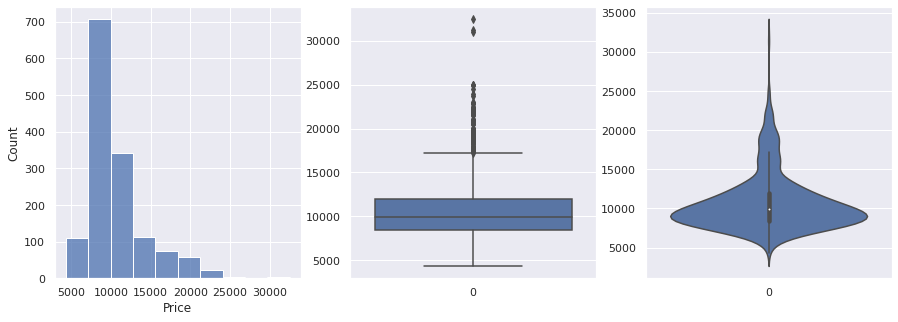

In [457]:
graficar_info_variable(df.Price, 10)

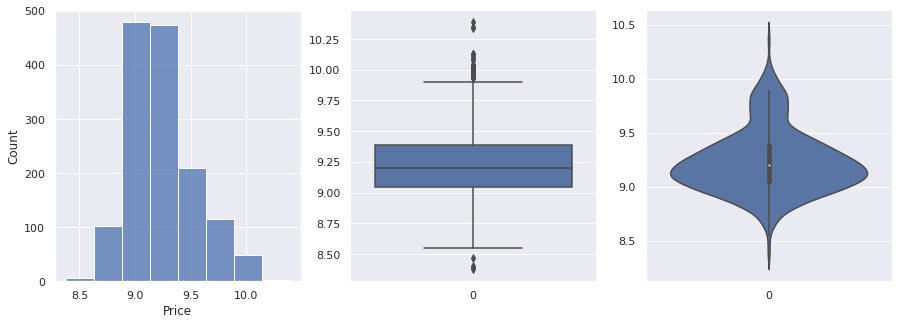

In [458]:
df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [459]:
porcentaje_outliers(df.Price)
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  2.8551532033426184
Porcentaje de outliers:  1.6487455197132617


### Mfg_Year

#### AGE_08_04

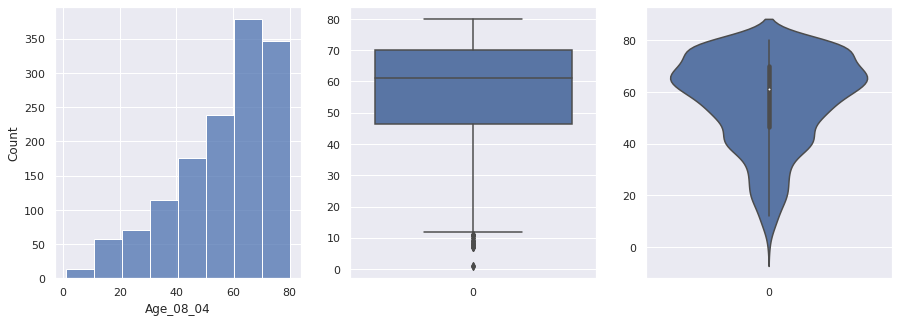

In [460]:
graficar_info_variable(df.Age_08_04)

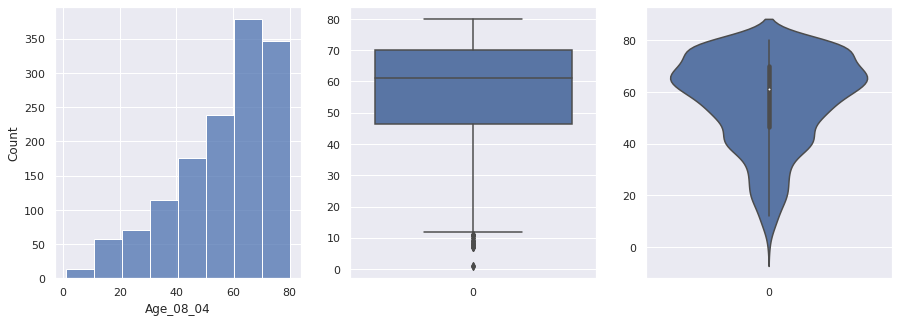

In [461]:
#df.Age_08_04 = qt.fit_transform(df.Age_08_04.values.reshape(-1, 1))
graficar_info_variable(df.Age_08_04)

In [462]:
porcentaje_outliers(df.Age_08_04)
df = quitar_outliers(df, df.Age_08_04)
porcentaje_outliers(df.Age_08_04)

Porcentaje de outliers:  1.3620071684587813
Porcentaje de outliers:  0.07267441860465117


#### KM

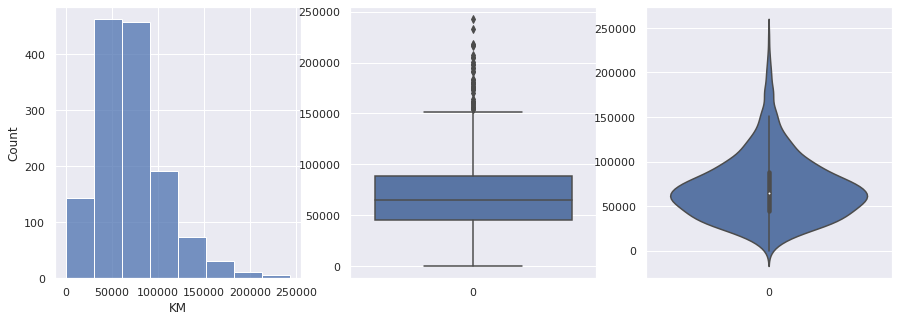

In [463]:
graficar_info_variable(df.KM)

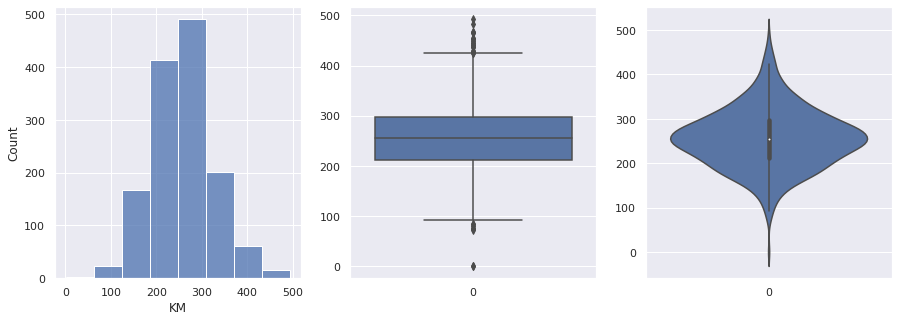

In [464]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [465]:
porcentaje_outliers(df.KM)
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  1.9622093023255813
Porcentaje de outliers:  0.5189028910303929


#### HP

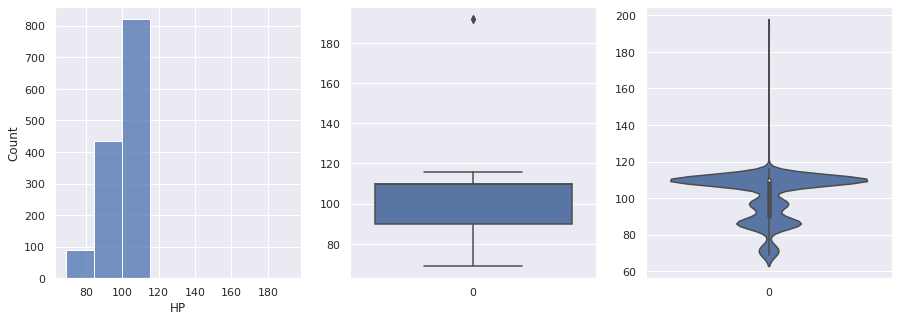

In [466]:
graficar_info_variable(df.HP)

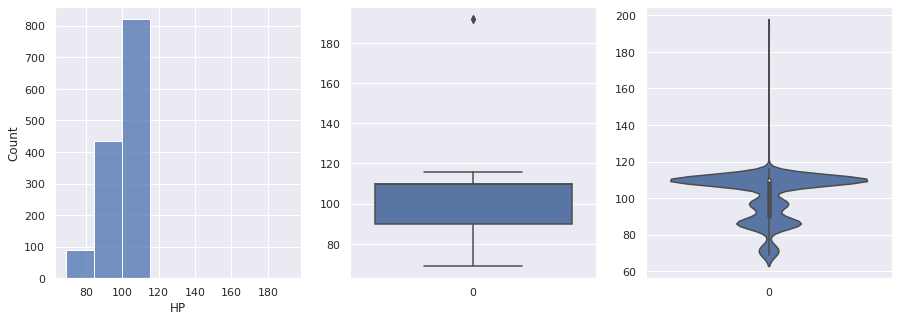

In [467]:
#df.HP = qt.fit_transform(df.HP.values.reshape(-1, 1))
graficar_info_variable(df.HP)

In [468]:
porcentaje_outliers(df.HP)
df = quitar_outliers(df, df.HP)

Porcentaje de outliers:  0.14825796886582654


#### Weight

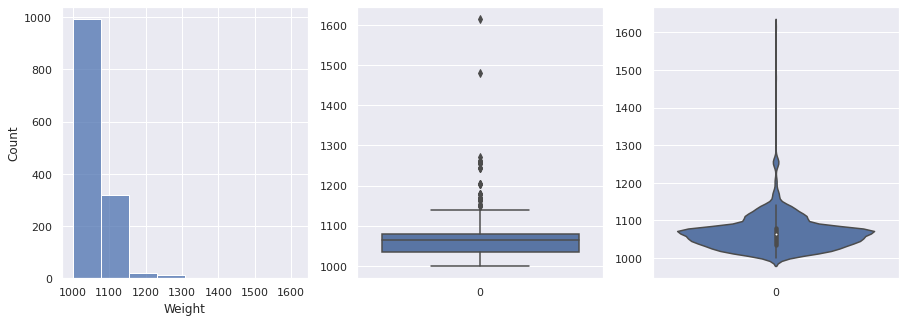

In [469]:
graficar_info_variable(df.Weight)

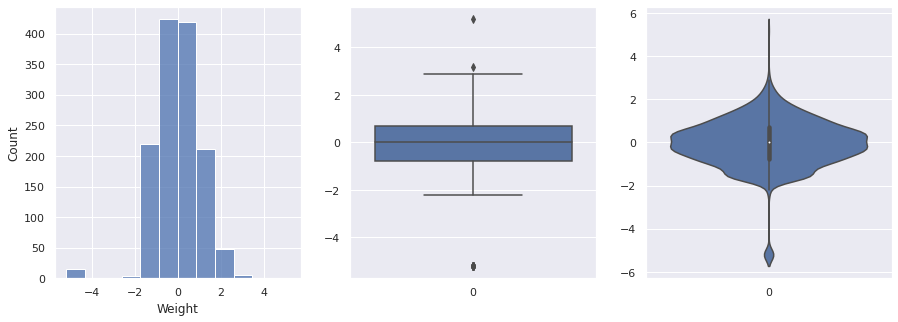

In [470]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [471]:
porcentaje_outliers(df.Weight)
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.3363028953229399
Porcentaje de outliers:  0.3009781790820166


#### Definir x e y

In [472]:
y = df.Price
x = df.drop(columns=['Price'])

#### Recursive feature elimination

In [473]:
lin_reg = LinearRegression()
rfe_mod = RFECV(lin_reg, step=1, cv=5)
#rfe_mod = RFE(lin_reg, n_features_to_select=4, step=1)
myvalues=rfe_mod.fit(x,y)
names=pd.DataFrame(x.columns)
rankings=pd.DataFrame(myvalues.ranking_)

In [474]:
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

,Feature,Rank
0,Age_08_04,1
1,Mfg_Month,1
2,Mfg_Year,1
3,KM,1
4,HP,2
5,Met_Color,1
6,Automatic,1
7,cc,3
8,Doors,1
9,Gears,1


#### Univariate Feature Selection

In [475]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'])

,Feature,Score
1,Mfg_Month,0.004091
34,Petrol,0.062846
29,Metallic_Rim,0.086686
9,Gears,0.371517
33,Diesel,0.378112
25,Radio,0.526469
30,Radio_cassette,0.654263
27,Sport_Model,0.823249
32,CNG,0.845153
6,Automatic,0.986831


#### LASSO

In [476]:
lasso = LassoCV(cv=5, random_state=0, max_iter=1000)
lasso.fit(x, y)

LassoCV(cv=5, random_state=0)

In [477]:
results_df=pd.DataFrame(lasso.coef_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Coef"]
scored.sort_values(by=['Coef'])

,Feature,Coef
0,Age_08_04,-0.010938
1,Mfg_Month,-0.007989
3,KM,-0.000870
20,Boardcomputer,-0.000000
21,CD_Player,0.000000
22,Central_Lock,0.000000
24,Power_Steering,-0.000000
25,Radio,-0.000000
26,Mistlamps,0.000000
27,Sport_Model,0.000000


#### Entrenar Modelo 1

In [478]:
ml_results = entrenar_modelo(df)

Mean squared error: 0.1505


In [479]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     196.9
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -471.59
No. Observations:                1063   AIC:                             1009.
Df Residuals:                    1030   BIC:                             1173.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0036      0.012      0.304      0.761      -0.020       0.027
Age_08_04           -0.3130      0.012    -25.974      0.000      -0.337      -0.289
Mfg_Month           -0.0486      0.012     -4.079      0.000      -0.072      -0.025
Mfg_Year             0.3264      0.012     26.761      0.000       0.302       0.350
KM                  -0.1919      0.016    -12.058      0.000      -0.223      -0.161
HP                   0.0196      0.023      0.856      0.392      -0.025       0.065
Met_Color           -0.0147      0.013     -1.163      0.245      -0.040       0.010
Automatic            0.0349      0.013      2.596      0.010       0.009       0.061
cc                   0.0005      0.012      0.042      0.967      -0.023       0.024
Doors                0.0124      0.017      0.750      0.453      -0.020       0.045
Gears                0.0335      0.013      2.489      0.013       0.007       0.060
Quarterly_Tax        0.1164      0.027      4.264      0.000       0.063       0.170
Weight               0.1552      0.029      5.340      0.000       0.098       0.212
Mfr_Guarantee        0.0784      0.013      6.087      0.000       0.053       0.104
BOVAG_Guarantee      0.0382      0.014      2.810      0.005       0.012       0.065
Guarantee_Period     0.0514      0.016      3.128      0.002       0.019       0.084
ABS                  0.0195      0.018      1.058      0.290      -0.017       0.056
Airbag_1            -0.0055      0.014     -0.386      0.700      -0.033       0.022
Airbag_2            -0.0232      0.022     -1.052      0.293      -0.066       0.020
Airco                0.0548      0.016      3.473      0.001       0.024       0.086
Automatic_airco      0.0600      0.014      4.296      0.000       0.033       0.087
Boardcomputer       -0.0229      0.018     -1.237      0.216      -0.059       0.013
CD_Player            0.0258      0.014      1.827      0.068      -0.002       0.054
Central_Lock        -0.0020      0.024     -0.081      0.935      -0.050       0.046
Powered_Windows      0.0803      0.025      3.268      0.001       0.032       0.129
Power_Steering      -0.0260      0.015     -1.679      0.093      -0.056       0.004
Radio               -0.0108      0.006     -1.683      0.093      -0.023       0.002
Mistlamps           -0.0044      0.017     -0.254      0.800      -0.038       0.029
Sport_Model         -0.0157      0.015     -1.072      0.284      -0.044       0.013
Backseat_Divider    -0.0054      0.020     -0.267      0.790      -0.045       0.034
Metallic_Rim         0.0038      0.014      0.280      0.780      -0.023       0.031
Radio_cassette      -0.0108      0.006     -1.682      0.093      -0.023       0.002
Tow_Bar             -0.0239      0.013     -1.893      0.059      -0.049       0.001
CNG                 -0.

#### Quitar features con p > |t|  mayores a 0.05

In [480]:
drop_columns = ['Met_Color', 'cc', 'Doors', 'ABS', 'Airbag_1', 'Airbag_2', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Power_Steering', 'Radio',
                'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Tow_Bar']
df = df.drop(columns=drop_columns)

#### Entrenar Modelo 2

In [481]:
ml_results = entrenar_modelo(df)

Mean squared error: 0.1453


In [482]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     389.2
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -483.92
No. Observations:                1063   AIC:                             1002.
Df Residuals:                    1046   BIC:                             1086.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0030      0.012      0.252      0.801      -0.020       0.026
Age_08_04           -0.3101      0.008    -36.770      0.000      -0.327      -0.294
Mfg_Month           -0.0481      0.012     -4.082      0.000      -0.071      -0.025
Mfg_Year             0.3233      0.009     37.672      0.000       0.306       0.340
KM                  -0.1949      0.016    -12.358      0.000      -0.226      -0.164
HP                   0.0138      0.020      0.673      0.501      -0.026       0.054
Automatic            0.0323      0.013      2.511      0.012       0.007       0.057
Gears                0.0281      0.012      2.253      0.024       0.004       0.053
Quarterly_Tax        0.0987      0.024      4.052      0.000       0.051       0.147
Weight               0.1634      0.022      7.475      0.000       0.120       0.206
Mfr_Guarantee        0.0770      0.013      6.090      0.000       0.052       0.102
BOVAG_Guarantee      0.0272      0.013      2.134      0.033       0.002       0.052
Guarantee_Period     0.0590      0.014      4.331      0.000       0.032       0.086
Airco                0.0570      0.015      3.767      0.000       0.027       0.087
Automatic_airco      0.0609      0.013      4.833      0.000       0.036       0.086
Powered_Windows      0.0764      0.014      5.344      0.000       0.048       0.104
CNG                 -0.0442      0.012     -3.694      0.000      -0.068      -0.021
Diesel              -0.0401      0.017     -2.345      0.019      -0.074      -0.007
Petrol               0.0538      0.016      3.315      0.001       0.022       0.086
==============================================================================
Omnibus:                       28.739   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.187
Skew:                           0.081   Prob(JB):                     3.13e-14
Kurtosis:                       4.174   Cond. No.                     8.54e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.78e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [483]:
df.corr().style.background_gradient(cmap='Greens')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Automatic,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,Airco,Automatic_airco,Powered_Windows,CNG,Diesel,Petrol
Price,1.000000,-0.866650,0.001756,0.876053,-0.581037,0.161244,0.027260,0.016730,0.157025,0.456877,0.248606,0.046891,0.085081,0.426940,0.394344,0.318253,-0.025229,0.016878,-0.006882
Age_08_04,-0.866650,1.000000,-0.155470,-0.979742,0.506724,-0.039377,0.053901,0.029348,-0.185203,-0.401198,-0.182771,-0.012325,-0.060165,-0.360822,-0.326154,-0.218370,-0.017995,-0.091950,0.093424
Mfg_Month,0.001756,-0.155470,1.000000,-0.045511,-0.018274,-0.053405,-0.001522,-0.013933,0.072222,0.051890,-0.015108,0.002776,0.000232,0.056631,-0.040001,0.036655,0.007438,0.086354,-0.084334
Mfg_Year,0.876053,-0.979742,-0.045511,1.000000,-0.508725,0.050647,-0.054200,-0.026853,0.172646,0.395195,0.187892,0.011901,0.060795,0.353404,0.337936,0.213398,0.016690,0.075479,-0.077379
KM,-0.581037,0.506724,-0.018274,-0.508725,1.000000,-0.231691,-0.073500,0.050190,0.258243,0.020439,-0.200542,-0.004874,-0.078047,-0.124127,-0.233447,-0.118806,0.130430,0.346144,-0.374252
HP,0.161244,-0.039377,-0.053405,0.050647,-0.231691,1.000000,0.009983,0.075004,-0.399857,0.050162,0.139526,0.002383,0.062103,0.232575,0.103754,0.260156,0.078584,-0.632005,0.569356
Automatic,0.027260,0.053901,-0.001522,-0.054200,-0.073500,0.009983,1.000000,-0.102943,-0.054810,0.090889,0.023621,0.014810,0.019563,-0.040287,0.060103,-0.010125,0.003283,-0.076502,0.071160
Gears,0.016730,0.029348,-0.013933,-0.026853,0.050190,0.075004,-0.102943,1.000000,-0.009492,-0.031412,-0.014737,0.070003,-0.043436,0.139058,-0.024469,0.124396,-0.051906,-0.040261,0.056749
Quarterly_Tax,0.157025,-0.185203,0.072222,0.172646,0.258243,-0.399857,-0.054810,-0.009492,1.000000,0.592208,-0.023198,0.084449,-0.138429,0.083882,-0.008071,-0.027637,0.259398,0.798552,-0.848463
Weight,0.456877,-0.401198,0.051890,0.395195,0.020439,0.050162,0.090889,-0.031412,0.592208,1.000000,0.003331,-0.009517,-0.002342,0.326617,0.276434,0.214906,0.101102,0.534696,-0.541996


In [484]:
drop_columns = ['Mfg_Month', 'Automatic', 'Gears', 'Quarterly_Tax', 'BOVAG_Guarantee', 'Guarantee_Period', 'CNG', 'Diesel', 'Petrol'] #por baja correlación con la variable objetivo
df = df.drop(columns=drop_columns)

#### Probar Modelo 3

In [485]:
ml_results = entrenar_modelo(df)

Mean squared error: 0.1619


In [486]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     656.7
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -510.63
No. Observations:                1063   AIC:                             1041.
Df Residuals:                    1053   BIC:                             1091.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0015      0.012      0.128      0.898      -0.022       0.025
Age_08_04          -0.0616      0.062     -1.000      0.317      -0.182       0.059
Mfg_Year            0.5630      0.061      9.179      0.000       0.443       0.683
KM                 -0.2144      0.015    -14.149      0.000      -0.244      -0.185
HP                  0.0265      0.013      2.021      0.044       0.001       0.052
Weight              0.1731      0.014     12.090      0.000       0.145       0.201
Mfr_Guarantee       0.0859      0.012      6.925      0.000       0.062       0.110
Airco               0.0602      0.015      3.926      0.000       0.030       0.090
Automatic_airco     0.0548      0.013      4.359      0.000       0.030       0.079
Powered_Windows     0.0801      0.014      5.551      0.000       0.052       0.108
==============================================================================
Omnibus:                       20.124   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.003
Skew:                          -0.066   Prob(JB):                     9.22e-09
Kurtosis:                       3.905   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [487]:
df.corr().style.background_gradient(cmap='Greens')

,Price,Age_08_04,Mfg_Year,KM,HP,Weight,Mfr_Guarantee,Airco,Automatic_airco,Powered_Windows
Price,1.000000,-0.866650,0.876053,-0.581037,0.161244,0.456877,0.248606,0.426940,0.394344,0.318253
Age_08_04,-0.866650,1.000000,-0.979742,0.506724,-0.039377,-0.401198,-0.182771,-0.360822,-0.326154,-0.218370
Mfg_Year,0.876053,-0.979742,1.000000,-0.508725,0.050647,0.395195,0.187892,0.353404,0.337936,0.213398
KM,-0.581037,0.506724,-0.508725,1.000000,-0.231691,0.020439,-0.200542,-0.124127,-0.233447,-0.118806
HP,0.161244,-0.039377,0.050647,-0.231691,1.000000,0.050162,0.139526,0.232575,0.103754,0.260156
Weight,0.456877,-0.401198,0.395195,0.020439,0.050162,1.000000,0.003331,0.326617,0.276434,0.214906
Mfr_Guarantee,0.248606,-0.182771,0.187892,-0.200542,0.139526,0.003331,1.000000,0.051631,0.030260,0.037983
Airco,0.426940,-0.360822,0.353404,-0.124127,0.232575,0.326617,0.051631,1.000000,0.195991,0.533786
Automatic_airco,0.394344,-0.326154,0.337936,-0.233447,0.103754,0.276434,0.030260,0.195991,1.000000,0.157600
Powered_Windows,0.318253,-0.218370,0.213398,-0.118806,0.260156,0.214906,0.037983,0.533786,0.157600,1.000000


In [438]:
#drop_columns = ['Age_08_04'] #Posible colinealidad
#df = df.drop(columns=drop_columns)

#### Prueba modelo 4

In [488]:
ml_results = entrenar_modelo(df)

Mean squared error: 0.1619


In [440]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     841.4
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:57:06   Log-Likelihood:                -513.02
No. Observations:                1063   AIC:                             1042.
Df Residuals:                    1055   BIC:                             1082.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0017      0.012      0.137      0.891      -0.022       0.025
Mfg_Year            0.6160      0.016     37.586      0.000       0.584       0.648
KM                 -0.2228      0.015    -15.185      0.000      -0.252      -0.194
Weight              0.1752      0.014     12.278      0.000       0.147       0.203
Mfr_Guarantee       0.0892      0.012      7.240      0.000       0.065       0.113
Airco               0.0659      0.015      4.351      0.000       0.036       0.096
Automatic_airco     0.0551      0.013      4.395      0.000       0.031       0.080
Powered_Windows     0.0842      0.014      5.877      0.000       0.056       0.112
==============================================================================
Omnibus:                       21.925   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.224
Skew:                          -0.099   Prob(JB):                     1.84e-09
Kurtosis:                       3.932   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [441]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [442]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:ylabel='Count'>

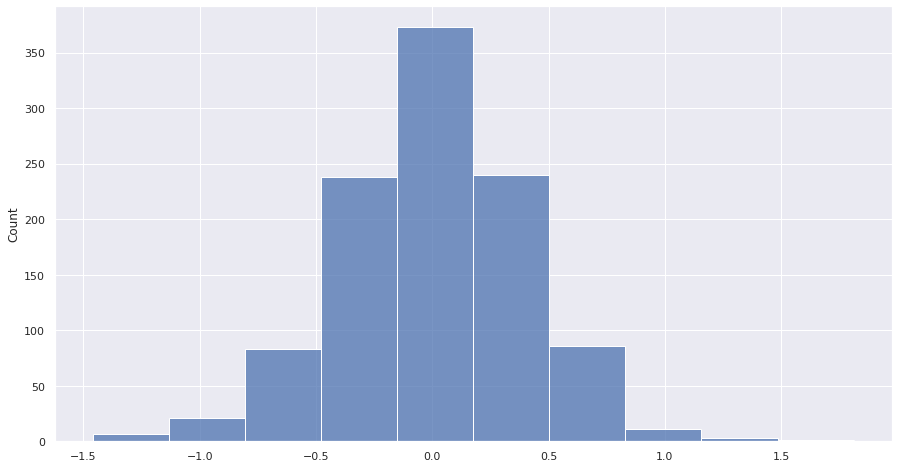

In [443]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

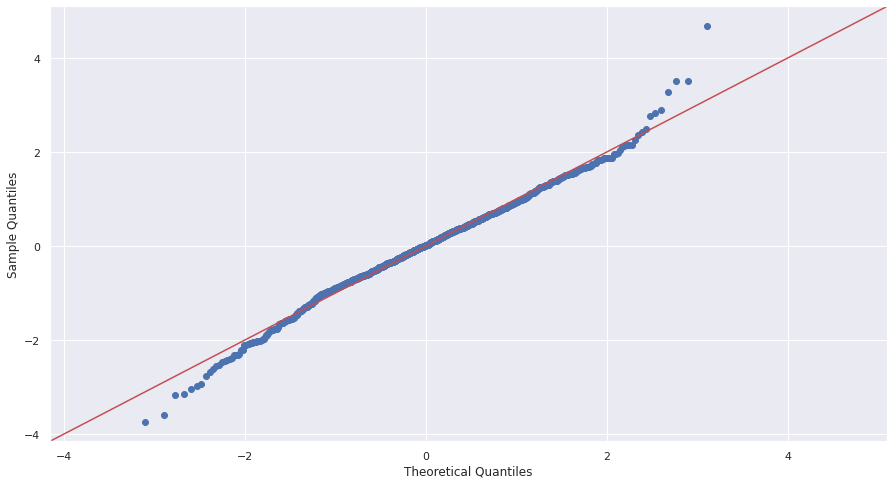

In [444]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

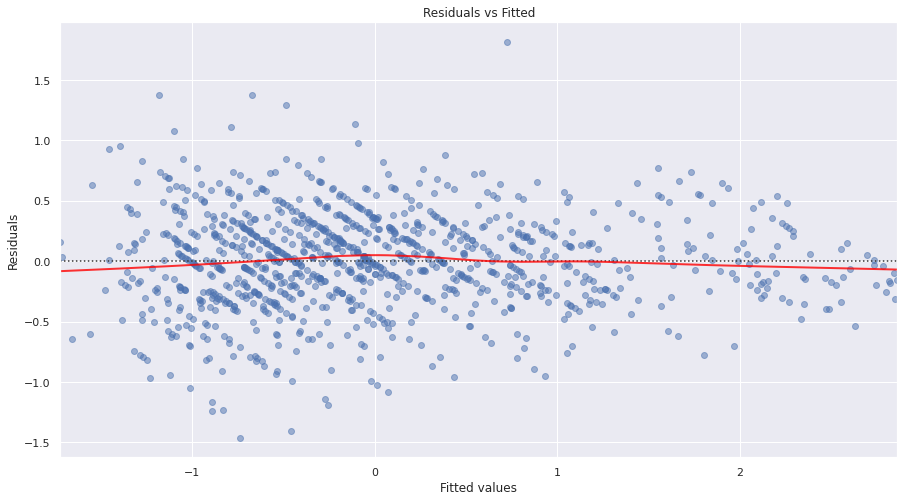

In [445]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()